In [75]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from IPython.display import display

In [76]:
# Load the scraped data
df = pd.read_csv('../dataset/anfragen_oldenburg_detailed.csv', encoding='utf-8')

# Pre-proccessing data

In [77]:
# Lowercasing
df['Beschreibung'] = df['Beschreibung'].str.lower()
display(df['Beschreibung'].head().apply(lambda x: repr(x) if pd.notna(x) else x))

# remove special chars and numbers
def clean_entries(entry):
    if pd.isna(entry):
        return ''
    # replace special hars and numbers
    entry = re.sub(r'\\d+', ' ', str(entry))
    entry = re.sub(r'[^\w\säöüß\\-]', ' ', entry)
    return ' '.join(entry.split())
df['Beschreibung'] = df['Beschreibung'].apply(clean_entries)

# remove stop words
nlp = spacy.load('de_core_news_sm')
def remove_stopwords(entry):
    if pd.isna(entry) or not entry.strip():
        return ''
    doc = nlp(entry)
    return ' '.join([token.text for token in doc if not token.is_stop and token.is_alpha])
df['Beschreibung'] = df['Beschreibung'].apply(remove_stopwords)

# lemmatize
def lemmatize(entry):
    if pd.isna(entry) or not entry.strip():
        return ''
    doc = nlp(entry)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    for token, lemma in zip(doc, lemmas):
        if token.text != lemma and token.is_alpha:
            print(f"Original: {token.text}, Lemma: {lemma}")
    return ' '.join(lemmas)
df['Beschreibung'] = df['Beschreibung'].apply(lemmatize)

def remove_street_names(entry):
   # remove words ending with straße, strasse, allee, gasse, or weg (except for einweg, which could be trash)
    pattern = r'\b(?!einweg\b)\w*(straße|strasse|str|weg|allee|gasse|nummer|nr)\b'
    return re.sub(pattern, ' ', entry, flags=re.IGNORECASE)
df['Beschreibung'] = df['Beschreibung'].apply(remove_street_names)

docs = df['Beschreibung'].dropna()

# TF-IDF-Vectorizing
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(docs)

# K-Means-Clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Cluster-Labels
labels = kmeans.labels_

print("Clustering done.")
print(f"Parameters initialized:")
print(f"Number of documents: {len(docs)}")
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Number of labels: {len(labels)}")

0    'wenn man von famila kommt und dann ist da die...
1    'ecke nadorster strasse / lindenhofsgarten ist...
2    'in dem gang bogenstrasse / goethestrasse höhe...
3    'am containerstellplatz ecke nedderend wurde d...
4                       'gefrier-kühlschrank abgelegt'
Name: Beschreibung, dtype: object

Original: famila, Lemma: Famila
Original: kreyenstr, Lemma: Kreyenstr
Original: liegt, Lemma: liegen
Original: müll, Lemma: Müll
Original: gebüsch, Lemma: Gebüsch
Original: ecke, Lemma: Ecke
Original: nadorster, Lemma: nadorst
Original: lindenhofsgarten, Lemma: lindenhofsgaren
Original: abfall, Lemma: Abfall
Original: abgelegt, Lemma: ablegen
Original: gang, Lemma: Gang
Original: höhe, Lemma: Höhe
Original: abfall, Lemma: Abfall
Original: entsorgt, Lemma: entsorgen
Original: containerstellplatz, Lemma: Containerstellplatz
Original: ecke, Lemma: Ecke
Original: hausmüll, Lemma: Hausmüll
Original: entsorgt, Lemma: entsorgen
Original: abgelegt, Lemma: ablegen
Original: straßenbeleuchtung, Lemma: Straßenbeleuchtung
Original: licht, Lemma: Licht
Original: alter, Lemma: alt
Original: küchlschrank, Lemma: Küchlschrank
Original: entsorgt, Lemma: entsorgen
Original: richtung, Lemma: Richtung
Original: norden, Lemma: Norden
Original: linken, Lemma: linker
Original: seite, Lemma: Seite
Original: s

# K-Means Clustering

In [78]:
def display_cluster_info(tfidf_matrix, labels, vectorizer, docs):
    order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
    terms = vectorizer.get_feature_names_out()

    print(f"Number of Clusters: {k}")
    print(f"Lenght of Labels: {len(labels)}")

    for i in range(k):
        cluster_docs = [doc for doc, label in zip(docs, labels) if label == i]
        print(f"Cluster {i}: - Number of documents before filtering: {sum(1 for label in labels if label == i)}")
        count = len(cluster_docs)
        top_words = [terms[ind] for ind in order_centroids[i, :5]] # top 5 words
        rep_docs = cluster_docs[:3] if cluster_docs else []

        print(f"Cluster {i}:")
        print(f"Number: {count}")
        print(f"Top words: {', '.join(top_words)}")
        print(f"Representative documents: {rep_docs if rep_docs else 'No Documents available'}")

display_cluster_info(tfidf_matrix, labels, vectorizer, docs)

Number of Clusters: 10
Lenght of Labels: 893
Cluster 0: - Number of documents before filtering: 31
Cluster 0:
Number: 31
Top words: sehen, foto, beschmiert, schild, brücke
Representative documents: ['Straßenbeleuchtung enorm zugewachsen Licht sehen', 'Parkplatz Kleingart gehören direkt   groß Menge Müll Sperrgut Abgelade z b ferner sehen erneut renovieren all brauchen hingeschmissen sehen Woche fühlen', '    stehen stark regenfäll Bereichsweis Wasser sodass kinderwag Rollstuhlfahrer Fahrbahn ausweichen sehen Foto Bereich   Einmündung heidelberger     ausreichend pflegen Entwässerung überprüfen   ausgebessern Begleitgrün abgesenkt Regenwasser versickern Mangel bestehen mehrere beachten Mangel gefährden Verkehrssicherheit']
Cluster 1: - Number of documents before filtering: 65
Cluster 1:
Number: 65
Top words: aufkleber, werbung, fußball, unterhaltungsfußball, vfb
Representative documents: ['vfb aufkleber', 'Aufkleber Werbung Unterhaltungsfußball vfb Oldenburg Fußball gmbh Verkehrszeich b

# Usage of t-SNE to reduce dimensions (visualization)

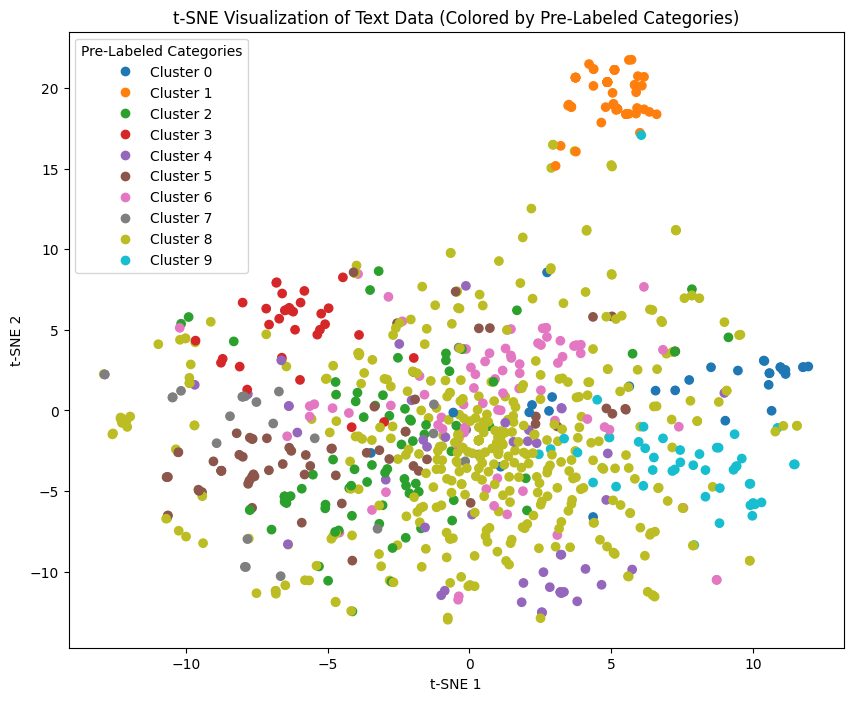

In [79]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10,8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')

plt.title('t-SNE Visualization of Text Data (Colored by Pre-Labeled Categories)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

legend_labels = [f'Cluster {i}' for i in range(k)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Pre-Labeled Categories")

plt.show()

In [80]:
import sklearn
print(sklearn.__version__)

1.7.0
